In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm

import pandas as pd
import os 
from glob import glob

import numpy as np
import cv2

import albumentations

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset

In [4]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs
from src.modules import dataset as ds
# from retinanet import model as retinanet
import src.models.retinanet.resnext
import src.models.retinanet.model
from src.models.retinanet import model as retinanet

%load_ext autoreload
%autoreload 2

In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
labels = pd.read_csv('../data/descr/labels.csv')

In [7]:
folds = ds.get_folds(labels, 4)
fold = ds.get_fold_split(folds, 0)
train_dataset = ds.BBoxDataset(labels, fold[0])
valid_dataset = ds.BBoxDataset(labels, fold[1])

In [8]:
train_datagen = DataLoader(train_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=True, collate_fn=ds.bbox_collater)
valid_datagen = DataLoader(valid_dataset, batch_size=config.PARAMS.BATCH_SIZE, shuffle=False, collate_fn=ds.bbox_collater)
for data in train_datagen:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


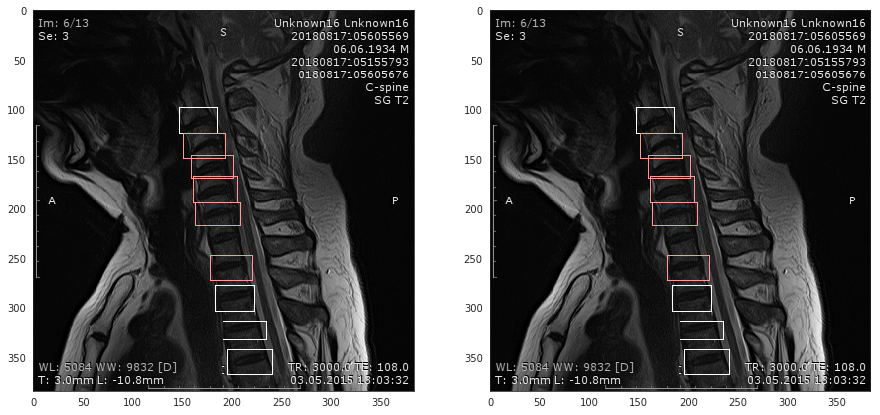

In [189]:
data = train_dataset[55]
img = vs.visualize_bboxes(data, data, {2: 'normal', 1: 'pathology'})

In [10]:
image = torch.autograd.Variable(data['image']).cuda()

In [11]:
focal_loss = retinanet.FocalLoss(iou_lower=.3, iou_upper=.5)
model = retinanet.resnet101(num_classes=2, focal_loss=focal_loss, pretrained=True, single_channel=True, make_clf=False)

Overlapped keys: 520
Poped keys: []
Summed over: weight


In [12]:
import torch

import numpy as np
from tqdm import tqdm
import numpy_indexed as npi

# from ..configs import config
# from ..utils import visualisation
# from . import dataset as ds

In [13]:
def get_model(model, checkpoint=None, map_location=None, devices=None):
    model.cuda()

    if checkpoint is not None:
        sd = torch.load(checkpoint, map_location) #.module.state_dict()
        msd = model.state_dict()
        sd = {k: v for k, v in sd.items() if k in msd}
        print('Overlapped keys: {}'.format(len(sd.keys())))
        msd.update(sd)
        model.load_state_dict(msd)

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model


def freeze(model, unfreeze=False):
    children = list(model.children())
    if hasattr(model, 'children') and len(children):
        for child in children:
            freeze(child, unfreeze)
    elif hasattr(model, 'parameters'):
        for param in model.parameters():
            param.requires_grad = unfreeze
            
            
def unfreeze_bn(model):
    predicat = isinstance(model, torch.nn.BatchNorm2d)
    predicat |= isinstance(model, bn.ABN)
    predicat |= isinstance(model, bn.InPlaceABN)
    predicat |= isinstance(model, bn.InPlaceABNSync)
    if predicat:
        for param in model.parameters():
            param.requires_grad = True

    children = list(model.children())
    if len(children):
        for child in children:
            unfreeze_bn(child)
    return None

In [14]:
class RetinaLearner:
    def __init__(self, model, opt=None, gclip=0.001):
        self.gclip = gclip
        self.threshold = 0.05

        self.model = model
        self.opt = opt

        if self.opt is not None:
            for group in self.opt.param_groups:
                group.setdefault('initial_lr', group['lr'])

    def make_step(self, data, training=False):
        image = torch.autograd.Variable(data['image']).cuda()
        annot = torch.autograd.Variable(data['bboxes']).cuda()

        prediction = self.model([image.float(), annot.float()])

        classification_loss, regression_loss = prediction['focal_loss']
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        results = { 
            'loss': classification_loss + regression_loss,
            'bbx_reg_loss': regression_loss,
            'bbx_clf_loss': classification_loss,
        }

        if training and bool(results['loss'] == 0):
            return results

        if training:
            results['loss'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gclip)
            self.opt.step()

        image = image.data.cpu()
        for key in results.keys():
                results[key] = results[key].data.cpu()
        return results

    def validate(self, datagen):
        torch.cuda.empty_cache()
        self.model.eval()
        meters = list()
        with torch.no_grad():
            for data in tqdm(datagen.dataset):
                meters.append(self.make_step(data, training=False))
        return meters

    def train_on_epoch(self, datagen, hard_negative_miner=None, lr_scheduler=None):
        torch.cuda.empty_cache()
        self.model.train()
        meters = list()

        for data in tqdm(datagen):
            meters.append(self.make_step(data, training=True))
            if lr_scheduler is not None:
                if hasattr(lr_scheduler, 'batch_step'):
                    lr_scheduler.batch_step(logs=meters[-1])

            if hard_negative_miner is not None:
                hard_negative_miner.update_cache(meters[-1], data)
                if hard_negative_miner.need_iter():
                    self.make_step(hard_negative_miner.get_cache(), training=True)
                    hard_negative_miner.invalidate_cache()

        return meters

    def save(self, path):
        state_dict = self.model.state_dict()
        if isinstance(self.model, torch.nn.DataParallel):
            state_dict = self.model.module.state_dict()
        torch.save(state_dict, path)
        print('Saved in {}:'.format(path))


In [15]:
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
model = get_model(model, devices=config.PARAMS.CUDA_DEVICES)
learner = RetinaLearner(model, opt)

In [16]:
history = list()
for i in range(10):
    print('Epoch: {}'.format(i))
    history.append(learner.train_on_epoch(train_datagen))

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 0


/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 9


100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


In [195]:
for data in valid_datagen:
    break

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


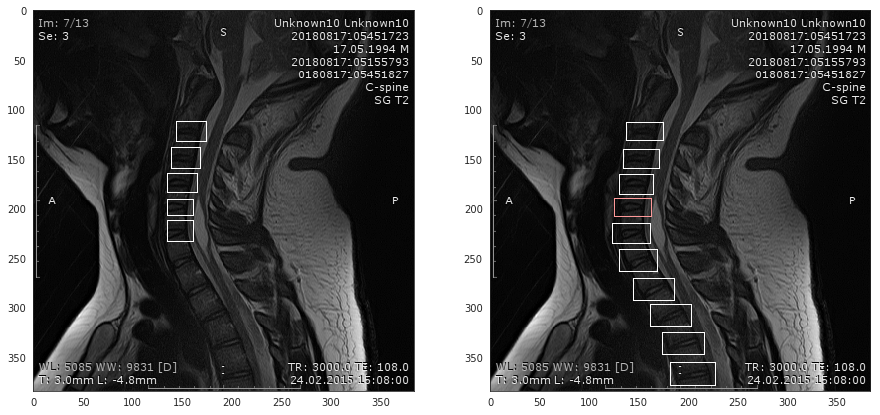

In [197]:
model.eval()
    
with torch.no_grad():
    output = model(data['image'].cuda().float()[:1])
    scores = output['nms_out'][0].cpu().numpy()
    labels = output['nms_out'][1].cpu().numpy()
    boxes  = output['nms_out'][2].cpu().numpy()

    bboxes = np.concatenate([
        boxes, 
        np.expand_dims(labels, -1),
    ], -1)
    bboxes = bboxes[scores > .1]

    fdata = {
        'image': data['image'][0],#.permute(1, 2, 0),
        'bboxes': bboxes.astype(np.int)
    }
    tdata = {
        'image': data['image'][0],#.permute(1, 2, 0),
        'bboxes': data['bboxes'][0][:5].data.numpy().astype(np.int)
    }
    vs.visualize_bboxes(tdata, fdata, {0:'', 1:''})

In [191]:
from collections import defaultdict


losses = defaultdict(list)
for epoch in history:
    for batch in epoch:
        for k, v in batch.items():
            losses[k].append(int(v))

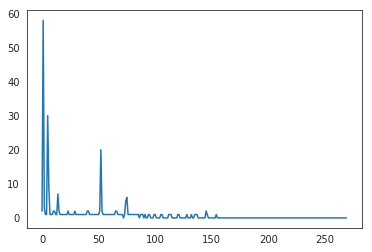

In [192]:
plt.plot(losses['loss'])